In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
from pydeseq2.preprocessing import deseq2_norm

In [2]:
# Load the metadata
#file_path_metadata = './silver_seq/silver_seq_metadata.xlsx'
file_path_metadata = "./toden/toden_metadata.xlsx"
metadata = pd.read_excel(file_path_metadata)

sample_name = 'Run'
target_name = 'Disease'

# Load the RNA-seq data from a text file
file_path_rna_seq =  "./toden/toden_counts_updown_genes.csv"
#file_path_rna_seq = './silver_seq/silver_seq_counts_updown_genes.csv'
rna_seq_data = pd.read_csv(file_path_rna_seq, index_col = 0)  # Adjust sep if necessary

# Transpose RNA-seq data to have samples as rows and genes as columns
rna_seq_data = rna_seq_data.T

#rna_seq_data_scaled = deseq2_norm(rna_seq_data)

#print('normed', rna_seq_data_scaled[0])

# Normalize the RNA-seq data (e.g., using StandardScaler)
scaler = StandardScaler()
rna_seq_data_scaled = scaler.fit_transform(rna_seq_data)

#rna_seq_scaled_df = pd.DataFrame(rna_seq_data_scaled , index=rna_seq_data.index)

#rna_seq_data.rename(columns={'index': 'sample_id_alias'}, inplace=True)
#rna_seq_scaled_df.index.names = ['sample_id_alias']

# Apply PCA to reduce dimensionality
pca_size = 50
pca = PCA(n_components=pca_size)  # Adjust n_components as needed
rna_seq_pca = pca.fit_transform(rna_seq_data_scaled)

# Convert PCA result to DataFrame and add sample identifiers
rna_seq_pca_df = pd.DataFrame(rna_seq_pca, index=rna_seq_data.index)
rna_seq_pca_df.reset_index(inplace=True)
rna_seq_pca_df.rename(columns={'index': sample_name}, inplace=True)

# Merge metadata with RNA-seq PCA data on 'sample_id_alias'
merged_data = pd.merge(metadata, rna_seq_pca_df, on=sample_name)

# Display the first few rows of the merged dataframe
# print(merged_data.head())

# Step 1: Label Encoding
label_encoder = LabelEncoder()
merged_data[target_name] = label_encoder.fit_transform(merged_data[target_name])

# Step 2: Feature Selection
# Use all columns except 'donor_id', 'donor_id_alias', 'sample_id_alias', 'year_sample', and 'donor_group' as features
#features = merged_data.drop(columns=['donor_id', 'donor_id_alias', 'sample_id_alias', 'year_sample', 'donor_group', 'donor_status_score', 'braak_stage', 'apoe_dose', 'apoe', 'apoe_carrier'])
features = merged_data[[i for i in range(pca_size)]]
print(features.head())
target = merged_data[target_name]

# Convert categorical features to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Convert boolean features to integers
features = features.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Ensure all features are numeric
features = features.apply(pd.to_numeric, errors='coerce')

# Fill any remaining NaNs with 0
features = features.fillna(0)

# Verify data types
print(features.dtypes)

# Step 3: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

          0         1         2         3         4         5         6   \
0   2.964390  3.810369 -1.927849 -0.762813 -0.359483 -0.869704 -0.946379   
1  10.435285 -1.138144 -2.748374  6.732220 -0.259409 -2.100701  0.320582   
2   9.253635  0.534057 -4.403132  5.821945 -0.417336 -1.723952  0.085118   
3   1.423447  3.607658 -1.918405 -5.917101 -2.405043 -0.020785 -0.634136   
4  -1.598702  2.227826 -2.126317 -0.299235 -0.693048 -0.508836 -1.328061   

         7         8         9   ...        40        41        42        43  \
0 -0.333967  1.101126  2.532909  ...  3.481509 -1.814386  1.254646  1.705258   
1  0.312036  0.036794 -1.163162  ... -0.695293  1.289084  0.609078  0.329655   
2  1.483472 -0.352500  1.829945  ...  2.156794 -0.101935 -1.976696  0.696211   
3 -2.384207  0.536403 -1.539390  ...  1.004176  2.539262  1.059277 -0.186318   
4  0.312192  1.354308  1.102579  ... -0.784495  0.482623 -0.548690  0.191416   

         44        45        46        47        48        49 

C:\Users\danie\AppData\Local\Temp\ipykernel_29728\3146780535.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: int(x) if isinstance(x, bool) else x)


In [3]:
# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [4]:
merged_data

,Run,Tissue,Age,PatientID,Ethnicity,Gender,Center,Disease,MMSE,CDR,...,40,41,42,43,44,45,46,47,48,49
0,SRR10192321,Plasma,75.0,434,NaN,Female,University of Washington at St. Louis,1,30.0,0.0,...,3.481509,-1.814386,1.254646,1.705258,-2.265775,0.050109,1.131240,-0.221753,-1.466128,0.205622
1,SRR10192320,Plasma,74.0,435,NaN,Female,University of Washington at St. Louis,1,30.0,0.0,...,-0.695293,1.289084,0.609078,0.329655,0.618270,-0.046983,0.984292,0.966053,2.368076,-1.569509
2,SRR10192319,Plasma,73.0,438,NaN,Female,University of Washington at St. Louis,1,29.0,0.0,...,2.156794,-0.101935,-1.976696,0.696211,0.436505,-0.355722,0.018680,0.273865,2.215694,-0.615265
3,SRR10192318,Plasma,68.0,447,NaN,Male,University of Washington at St. Louis,1,29.0,0.0,...,1.004176,2.539262,1.059277,-0.186318,0.321049,-0.757139,0.880422,-1.086372,0.046264,0.045799
4,SRR10192317,Plasma,68.0,447,NaN,Male,University of Washington at St. Louis,1,29.0,0.0,...,-0.784495,0.482623,-0.548690,0.191416,-2.337046,0.845616,-1.227724,-0.006489,-0.247271,-1.273513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,SRR10192327,Plasma,87.0,2657,Caucasian,Female,BioIVT,1,NaN,NaN,...,0.248079,-0.133847,0.191157,-0.150367,0.057844,0.253341,-0.007268,-0.112791,-0.329009,0.094441
330,SRR10192326,Plasma,86.0,2658,African American,Male,BioIVT,1,NaN,NaN,...,0.228373,0.491449,-0.105547,0.823327,-0.157512,2.650300,-0.612308,-0.404227,0.911500,1.945323
331,SRR10192325,Plasma,65.0,2659,Hispanic,Female,BioIVT,1,NaN,NaN,...,-0.246911,-0.095393,0.016741,0.023821,0.019873,0.084100,-0.068444,0.029899,0.012235,0.095962
332,SRR10192324,Plasma,66.0,2660,Hispanic,Male,BioIVT,1,NaN,NaN,...,0.071980,0.387587,0.254488,-0.250873,-0.009613,0.433077,0.070228,0.238389,-0.367958,0.034028


In [5]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
num_classes = 2  # Binary classification: AD or N

model = SimpleNN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 200

best_model = model
best_f1 = float('-inf')

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data to GPU
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the test set after each epoch
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, targets in test_loader:
            # Move data to GPU
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    if f1 > best_f1:
        best_model = copy.deepcopy(model)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, F1 Score: {f1:.4f}')

# Evaluate the model and calculate AUC
best_model.eval()
all_targets = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        # Move data to GPU
        data, targets = data.to(device), targets.to(device)
        
        outputs = best_model(data)
        _, predicted = torch.max(outputs.data, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

accuracy = 100 * correct / total

# Calculate AUC
auc = roc_auc_score(all_targets, all_probabilities)

f1 = f1_score(all_targets, all_predictions, average='weighted')
print(f'F1 car : {f1}')
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
print(f'AUC of the model on the test set: {auc:.4f}')

Epoch [1/200], Loss: 0.8826, F1 Score: 0.3756
Epoch [2/200], Loss: 0.8781, F1 Score: 0.3756
Epoch [3/200], Loss: 0.8682, F1 Score: 0.3756
Epoch [4/200], Loss: 0.4909, F1 Score: 0.3756
Epoch [5/200], Loss: 0.8770, F1 Score: 0.3756
Epoch [6/200], Loss: 0.3748, F1 Score: 0.3756
Epoch [7/200], Loss: 0.7931, F1 Score: 0.3756
Epoch [8/200], Loss: 0.4796, F1 Score: 0.3756
Epoch [9/200], Loss: 0.5760, F1 Score: 0.3756
Epoch [10/200], Loss: 0.6021, F1 Score: 0.3756
Epoch [11/200], Loss: 0.8420, F1 Score: 0.3756
Epoch [12/200], Loss: 0.5632, F1 Score: 0.3756
Epoch [13/200], Loss: 0.3873, F1 Score: 0.4082
Epoch [14/200], Loss: 0.4636, F1 Score: 0.4685
Epoch [15/200], Loss: 0.1439, F1 Score: 0.5489
Epoch [16/200], Loss: 0.1404, F1 Score: 0.6076
Epoch [17/200], Loss: 0.4570, F1 Score: 0.6292
Epoch [18/200], Loss: 0.5928, F1 Score: 0.6899
Epoch [19/200], Loss: 0.6201, F1 Score: 0.6636
Epoch [20/200], Loss: 0.5600, F1 Score: 0.6505
Epoch [21/200], Loss: 0.5828, F1 Score: 0.6557
Epoch [22/200], Loss: 

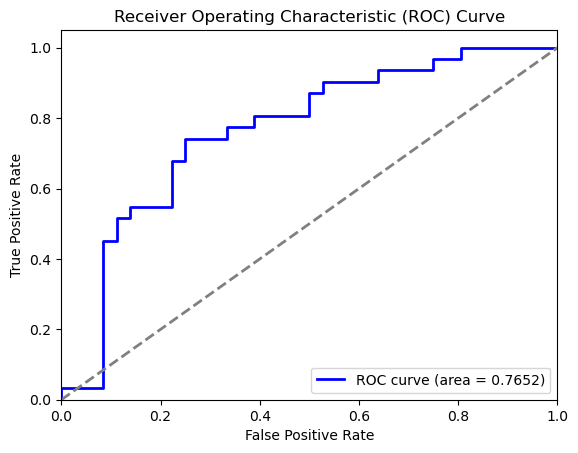

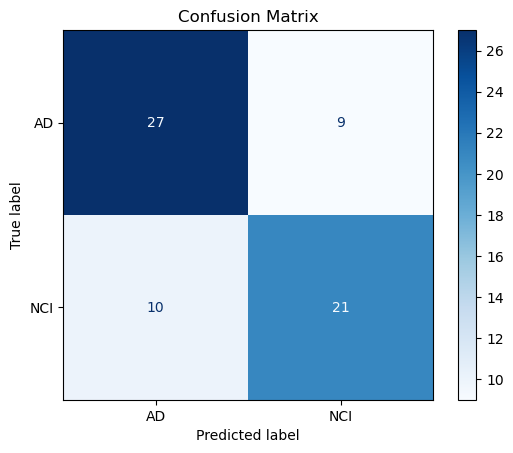

In [6]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [7]:
#toden_path = "./toden/toden_counts_updown_genes.csv"
toden_path = './silver_seq/silver_seq_counts_updown_genes.csv'
toden_data = pd.read_csv(toden_path, index_col = 0)

In [8]:
print(toden_data)

                 AD_1_02_1  AD_1_04_1  AD_1_08_1  AD_1_09_1  AD_1_11_1  \
index                                                                    
ENSG00000078369         11          4         19         32         32   
ENSG00000130939         20         11          9         19         46   
ENSG00000162545          4          9          3          6          1   
ENSG00000173372          0          0          2          4          3   
ENSG00000004455         19          6          8         16         29   
...                    ...        ...        ...        ...        ...   
ENSG00000182858          1          2          0         11          5   
ENSG00000142192         14         19         14         15         12   
ENSG00000156273         18         24         28         11         20   
ENSG00000159082         28         17         43         31         35   
ENSG00000197381         14         16         31         23         23   

                 AD_1_13_1  AD_2_01_1

In [9]:
#toden_metadata_path = "./toden/toden_metadata.xlsx"
toden_metadata_path = './silver_seq/silver_seq_metadata.xlsx'
toden_metadata = pd.read_excel(toden_metadata_path)

In [10]:
print(toden_metadata)

     donor_id donor_id_alias sample_id_alias  year_sample donor_status_score  \
0        8140           AD_1       AD_1_02_1         2002                  A   
1        8140           AD_1       AD_1_04_1         2004                  A   
2        8140           AD_1       AD_1_08_1         2008                  A   
3        8140           AD_1       AD_1_09_1         2009                  A   
4        8140           AD_1       AD_1_11_1         2011                  A   
..        ...            ...             ...          ...                ...   
110       647            N_9        N_9_00_1         2000                N--   
111       647            N_9        N_9_03_1         2003                 N-   
112       647            N_9        N_9_06_1         2006                  N   
113       647            N_9        N_9_08_1         2008                  N   
114       647            N_9        N_9_12_1         2012                  N   

    donor_group  braak_stage  apoe apoe

In [11]:


#rna_seq_data.rename(columns={'index': 'sample_id_alias'}, inplace=True)
sample_name = 'sample_id_alias'
target_name = 'donor_group'


# Transpose RNA-seq data to have samples as rows and genes as columns
toden_data = toden_data.T

# Normalize the RNA-seq data (e.g., using StandardScaler)
scaler = StandardScaler()
toden_data_scaled = scaler.fit_transform(toden_data)

#rna_seq_scaled_df = pd.DataFrame(rna_seq_data_scaled , index=rna_seq_data.index)

#rna_seq_data.rename(columns={'index': 'sample_id_alias'}, inplace=True)
#rna_seq_scaled_df.index.names = ['sample_id_alias']

# Apply PCA to reduce dimensionality
toden_seq_pca = pca.transform(toden_data_scaled)

toden_data_df = pd.DataFrame(toden_seq_pca , index=toden_data.index)
toden_data_df.index.names = [sample_name]
toden_merged_data = pd.merge(toden_metadata, toden_data_df, on=sample_name)

In [12]:
print(toden_metadata)

     donor_id donor_id_alias sample_id_alias  year_sample donor_status_score  \
0        8140           AD_1       AD_1_02_1         2002                  A   
1        8140           AD_1       AD_1_04_1         2004                  A   
2        8140           AD_1       AD_1_08_1         2008                  A   
3        8140           AD_1       AD_1_09_1         2009                  A   
4        8140           AD_1       AD_1_11_1         2011                  A   
..        ...            ...             ...          ...                ...   
110       647            N_9        N_9_00_1         2000                N--   
111       647            N_9        N_9_03_1         2003                 N-   
112       647            N_9        N_9_06_1         2006                  N   
113       647            N_9        N_9_08_1         2008                  N   
114       647            N_9        N_9_12_1         2012                  N   

    donor_group  braak_stage  apoe apoe

In [13]:
toden_target = toden_merged_data[target_name]
toden_target = toden_target.apply(lambda x: 1 if 'AD' in x else 0)

# Convert categorical features to dummy variables
toden_features = toden_merged_data[[i for i in range(pca_size)]]
toden_features = pd.get_dummies(toden_features, drop_first=True)


# Convert boolean features to integers
toden_features = toden_features.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Ensure all features are numeric
toden_features = toden_features.apply(pd.to_numeric, errors='coerce')

# Fill any remaining NaNs with 0
toden_features = toden_features.fillna(0)

C:\Users\danie\AppData\Local\Temp\ipykernel_29728\3200925115.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  toden_features = toden_features.applymap(lambda x: int(x) if isinstance(x, bool) else x)


In [14]:
print(toden_features)

           0         1         2         3         4         5         6   \
0   -4.648801 -0.374341 -0.831957  0.960998  0.429521  1.149074  1.120492   
1   -4.421280  0.830901 -1.588050 -0.604424 -0.709054 -1.565366  0.306329   
2   -1.716118  0.700169 -0.721894  0.001136 -0.372829 -0.070566 -0.396599   
3    1.427219  0.633720  0.871945  0.127323 -0.760391 -0.153228 -0.675365   
4    3.105068 -0.864461  0.468919  1.617777 -0.265874 -0.977587 -0.175974   
..        ...       ...       ...       ...       ...       ...       ...   
110  4.137416  1.713543  1.344067  2.706363  0.668801  0.999749 -1.593478   
111  5.277265 -0.096668  1.262189  0.167013  0.386523 -1.393808 -1.569522   
112 -7.386392 -0.993156 -1.780737 -0.039350 -0.649117  0.403465  0.185857   
113 -2.644912  0.243899  0.509889  0.393466 -0.452412 -0.402281 -0.432531   
114  5.154149 -0.712128  0.673379 -0.242772 -0.453817 -0.567489  0.223566   

           7         8         9   ...        40        41        42  \
0  

In [15]:
eval_x_tensor = torch.tensor(toden_features.values, dtype=torch.float32)
eval_y_tensor = torch.tensor(toden_target.values, dtype=torch.float32)

In [16]:
eval_dataset = TensorDataset(eval_x_tensor, eval_y_tensor)
eval_loader = DataLoader(eval_dataset, batch_size=16)

In [17]:
model.eval()
all_targets = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in eval_loader:
        # Move data to GPU
        data, targets = data.to(device), targets.to(device)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

accuracy = 100 * correct / total

# Calculate AUC
auc = roc_auc_score(all_targets, all_probabilities)

print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
print(f'AUC of the model on the test set: {auc:.4f}')

Accuracy of the model on the test set: 51.30%
AUC of the model on the test set: 0.6114


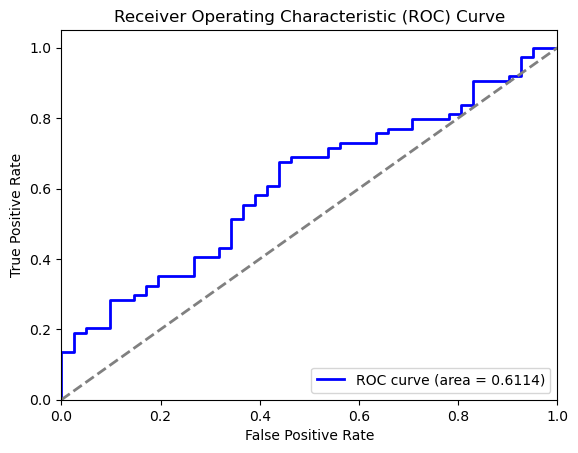

In [18]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

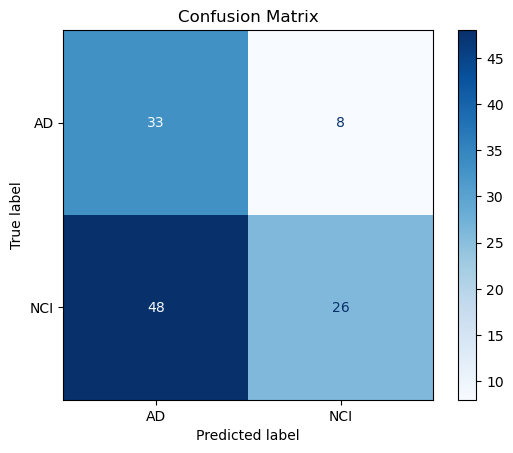

In [19]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()